In [1]:
import scprep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import graphtools as gt
from collections import Counter
import seaborn as sns
import tasklogger
import sklearn
import sklearn.cluster
import sklearn.mixture
import leidenalg as louvain
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
import os
from skimage import io as imio
from skimage import exposure
import scipy
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr

## Definitions and metadata

In [2]:
# EXTRACT STAINING SCHEME FROM DIRECTORY NAMES

# we assume the image data is stored in the a subdirectory for each round of staining
# with the name <PREFIX>_RD<ROUNDNUMBER>_<STAIN1>_<STAIN2>_<STAIN3>
# where <PREFIX> is a fixed prefix (experiment name) and <STAINX> is the name of the stain (both not containing _)
# <ROUNDNUMBER> is assumed to range over consecutive integers starting at 1

dataDir = os.path.join(os.getcwd(), 'processed_data'); 

# get the subdirs that contain the data for each round
stainDataDirs = [g for g in os.listdir(dataDir) if '_RD' in g];

# sort so order in list corresponds to round numbers
stainDataDirs.sort()

# determine which element of the split directory name corresponds to the round number
rdidx = [i for i,j in enumerate(str.split(stainDataDirs[0],'_')) if j.startswith('RD')][0]; 

# list of stains for each round
rd2stains = [str.split(g,'_')[rdidx+1:] for g in stainDataDirs];

# make flat list of unique stains in experiment
allstains = []; 
for i in range(0,len(rd2stains)):
    allstains = list(set(allstains + rd2stains[i]))

# create dictionary to get rounds in which each stain occurs (can be multiple time)
stain2rd = {};
for s in allstains:
    stain2rd[s] = [i+1 for i,j in enumerate(rd2stains) if s in j];

In [3]:
def getImageFilename(coli, stain, imtype='MIP'):
    
    # add _N for round N stain if stain was repeated, 
    # defaults to first round in which a stain occurs
    s = str.split(stain,'_');
    stain = s[0];
    if len(s)==1:
        stainrep = 0;
    else:
        stainrep = int(s[1])-1;
    
    if stain.startswith('DAPI') :
        ci = 0;
        if len(s)==2:
            rd = stainrep + 1;
        else:
            rd = 1;
    else:
        rd = stain2rd[stain][stainrep] - 1;
        ci = rd2stains[rd].index(s[0]) + 1;

    if imtype == 'MIP':    
        filepath = os.path.join(dataDir, stainDataDirs[rd], 'MIP', 'stitched_MIP_p{0}_w{1}_t0000.jpg');
        # colony numbers start from 1 but in the filenames we start from 0 (col 1 = p0000)
        fname = filepath.format('%.4d' % (coli-1), '%.4d' % ci);
    
    elif imtype == 'segOverlay':

        # CHECK THAT THIS IS THE RIGHT FORMAT
        filepath = os.path.join(dataDir, stainDataDirs[rd], 'MIP', 'aligned_segoverlay_p{0}.tif');
        fname = filepath.format('%.4d' % (coli-1));
        
    else:
        print('imtype not recognized, should be MIP or segOverlay')
        
    return fname

def adjust_contrast(im, tol):
    Imin, Imax = np.percentile(im[im>0], tol)
    im_rescale = exposure.rescale_intensity(im, in_range=(Imin,Imax),out_range=(0,255))
    return(im_rescale)

def makeRGBoverlay(coli, markers,tol = [[1,99],[1,99],[1,99]]):
    
    MIPca = {}

    for i, m in zip(range(0,len(markers)), markers):

        fname = getImageFilename(coli, m) 
        print('loading', fname)
        MIP = imio.imread(fname)
        MIPca[m] = adjust_contrast(MIP, tol=tol[i]);

    
    if len(markers)==3:
        RGBoverlay = np.stack([MIPca[markers[0]], MIPca[markers[1]], MIPca[markers[2]]], axis = 2)
    elif len(markers)==2:
        RGBoverlay = np.stack([MIPca[markers[0]], MIPca[markers[1]], 0*MIPca[markers[0]]], axis = 2)
    else: 
        RGBoverlay = MIPca[markers[0]];
        
    RGBoverlay=RGBoverlay.astype(np.uint8)
        
    return RGBoverlay

## Load cell data matrix

In [4]:
# load csv data from "data" folder
# change name of csv file if needed to examine other experiment

# This example data was generated for 9 round experiment, with stains as described in Table 1 of 
# the Current Protocols paper, with N=4 colonies, BMP4 treated and fixed at 48h
csvDir= os.path.join(os.getcwd(), 'data', '230713_CP_alldata.csv')

raw_data = pd.read_csv(csvDir)
#list(raw_data.columns)

In [5]:
# select relevant info : drop cytoplasmic values for purely nuclear stains etc
# stains that are repeated are indicated with an underscore "_" + (index of stain)
# e.g. SOX17_1 indicates the SOX17 measurements from round 1, SOX17_2 indicates the second SOX17 stain, 
# which was performed in this example in round 7

marker_list = ['TFAP2C', 'TBXT', 'SOX17_1', 'ISL1', 'NANOG', 'SOX2', 'HAND1', 'OCT4', 'CDX2', 
               'MIXL1', 'PRDM1', 'FOXA2', 'OTX2', 'SNAI1', 'EOMES', 'TBX6']
signal_list = ['cytopERK', 'pSmad1', 'BCAT', 'LEF1', 'ncSMAD2-3', 'ncYAP', 'cytopAKT']
meta_list = ['nucArea', 'nucVolume', 'nucZ', 'Z', 'nucMajorAxis', 'nucMinorAxis', 'nucCircularity', 
             'nucSolidity', 'Colony', 'X', 'Y', 'RadialDist'] # 'nucOrientation', 
keep_list = ['DAPI_1'] + marker_list + signal_list + meta_list;

data = raw_data[keep_list]
data

DAPI_1       TFAP2C        TBXT      SOX17_1         ISL1  \
0      1726.291008  1840.331769  529.007164   651.272480  3060.363142   
1      1908.071391  1851.237882  536.871970   653.694152  3497.413330   
2      2229.243254  3972.144999  654.466476  3786.431862  2810.940720   
3      2128.773525  1576.640663  555.964164   665.380546  3803.147245   
4      2273.316639  3035.966213  542.039617  2840.124383  2696.220511   
...            ...          ...         ...          ...          ...   
20551  2497.015584   616.999026  510.325000   559.954870   521.259740   
20552  1808.555518   658.670922  634.244415   581.640181   536.051907   
20553  1794.944465   696.195565  554.468658   577.645711   526.684567   
20554  1871.128012   791.654782  512.528596   609.667681   531.796666   
20555  1855.656274   740.459470  521.302806   627.333983   541.589634   

             NANOG         SOX2        HAND1         OCT4         CDX2  ...  \
0       682.618330   627.329298  2990.503211  1145.701581  1993.645504  ...   
1       709.020021   712.556902  3264.273973  1341.138830  2706.519758  ...   
2      4203.188880   592.421232   807.483919  2071.933361  2991.241483  ...   
3       835.068747   773.363359  2372.927231  1553.202340  2558.063262  ...   
4      3106.728659   587.460009   996.095679  1893.838391  2624.465839  ...   
...            ...          ...          ...          ...          ...  ...   
20551  2214.614286  2161.636364   604.916558  1183.101623   653.115260  ...   
20552  2947.011591  2274.025533   613.888628  2021.804636   683.907442  ...   
20553  2672.923021  2463.063966   591.996334  2831.594208   645.664773  ...   
20554  3342.589681  3524.250183   627.671210  2325.376369   664.110246  ...   
20555  2881.632892  4324.729540   633.637568  1675.264614   702.479735  ...   

       nucZ          Z  nucMajorAxis  nucMinorAxis  nucCircularity  \
0         4   4.088192     37.101961     24.293895        0.807593   
1         5   4.090622     34.112315     26.166318        0.801666   
2         7   5.558735     49.833045     26.852833        0.670469   
3         5   4.498537     49.204143     32.699891        0.666415   
4         6   4.480191     42.088892     35.159342        0.789128   
...     ...        ...           ...           ...             ...   
20551    26  24.547727     40.428347     21.425684        0.703731   
20552    21  20.964388     44.462113     30.713170        0.772077   
20553    25  24.094758     36.919416     31.256263        0.807324   
20554    21  17.845826     35.977400     29.058314        0.773802   
20555    23  22.519096     33.053113     25.956154        0.820150   

       nucSolidity  Colony            X            Y  RadialDist  
0         0.852570       1   584.611354  1859.786026  343.557835  
1         0.852076       1   647.290088  1899.513120  337.257214  
2         0.787762       1   680.409771  1965.380857  345.322015  
3         0.801407       1   708.352452  2000.375727  348.054999  
4         0.824174       1   707.212729  1959.189189  338.059279  
...            ...     ...          ...          ...         ...  
20551     0.765598       4  1222.639370  1677.206299  172.513599  
20552     0.772916       4  1039.195673   725.398871  208.663049  
20553     0.845629       4  1169.602235   706.324022  188.572175  
20554     0.513818       4  1012.772448  1395.206642  159.613550  
20555     0.900351       4  1537.202399   844.013493  119.699480  

[20556 rows x 36 columns]

## Inspect overlays

loading /Users/emily/LocalHeemskerkLab/Papers/code/processed_data/230110_6i9rd_exp20_RD1_SMAD23_pAKT_SOX17/MIP/stitched_MIP_p0003_w0003_t0000.jpg
loading /Users/emily/LocalHeemskerkLab/Papers/code/processed_data/230111_6i9rd_exp20_RD2_GATA3_OTX2_LEF1/MIP/stitched_MIP_p0003_w0002_t0000.jpg
loading /Users/emily/LocalHeemskerkLab/Papers/code/processed_data/230115_6i9rd_exp20_RD6_BCAT_TBX6_SMAD2/MIP/stitched_MIP_p0003_w0002_t0000.jpg


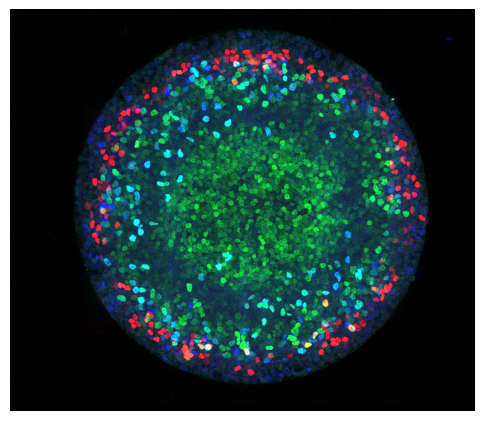

In [6]:
# example channel overlay

plt.rcParams['figure.figsize']=(6,6) 
stains = ['SOX17','OTX2','TBX6'] # three goat antibodies overlaid
coli = 4; # colony index

tol = [[1,99],[1,99],[1,99]] # tolerances for contrast adjustment
RGBoverlay = makeRGBoverlay(coli, stains, tol)
plt.imshow(RGBoverlay);
plt.axis('off');

## Quality control

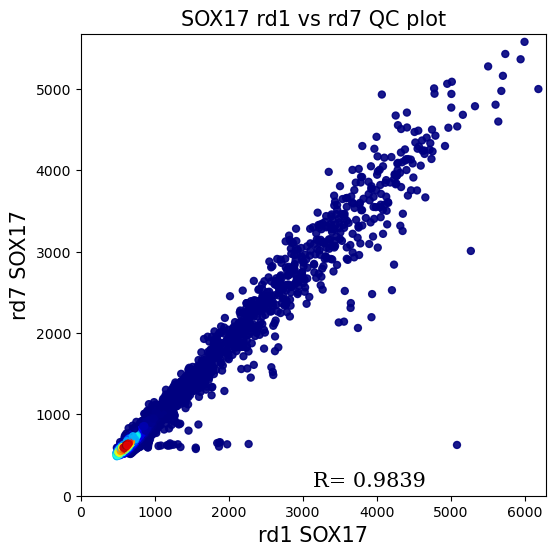

In [7]:
# Check strength of SOX17 self correlation
alevel=0.9
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 15,
        }
pntsize=25

#specify stains
stain1='SOX17_1'
stain2='SOX17_2'

#set limits based on maximums with buffer room
xlim=max(raw_data[stain1])+100
ylim=max(raw_data[stain2])+100

#set location for correlation text
fx=xlim*0.5
fy=ylim*0.02
fig, (ax) = plt.subplots(1, 1, figsize=(6,6))

# Color points by point density
xy = np.vstack([raw_data[stain1],raw_data[stain2]])
z = gaussian_kde(xy)(xy)

#plot
g=ax.scatter(raw_data[stain1], raw_data[stain2],c=z,cmap=plt.cm.jet, s = pntsize,  alpha=alevel)
ax.text(fx, fy, f'R= {round(pearsonr(raw_data[stain1], raw_data[stain2])[0],4)}', fontdict=font)
plt.title('SOX17 rd1 vs rd7 QC plot',fontsize = 15)
ax.set_ylabel(stain2, fontsize = 15)
ax.set_xlabel(stain1, fontsize = 15)
ax.set_xlim(0, xlim)
ax.set_ylim(0, ylim)
ax.set_xlabel('rd1 SOX17')
ax.set_ylabel('rd7 SOX17');

In [8]:
# check if there are any NaN values for cells
# these can be generated by cells that were cutoff from imaging in some round
# print(np.sum(np.isnan(data), axis=0))

# if numbers are small (~0.1% of total) they can be excluded here, otherwise it may be necessary to acquire better data
print('removing ' + str(np.sum(np.sum(np.isnan(data)))) + ' cells with NaN values in some channel')
data = data[~np.any(np.isnan(data), axis=1)];

removing 21 cells with NaN values in some channel


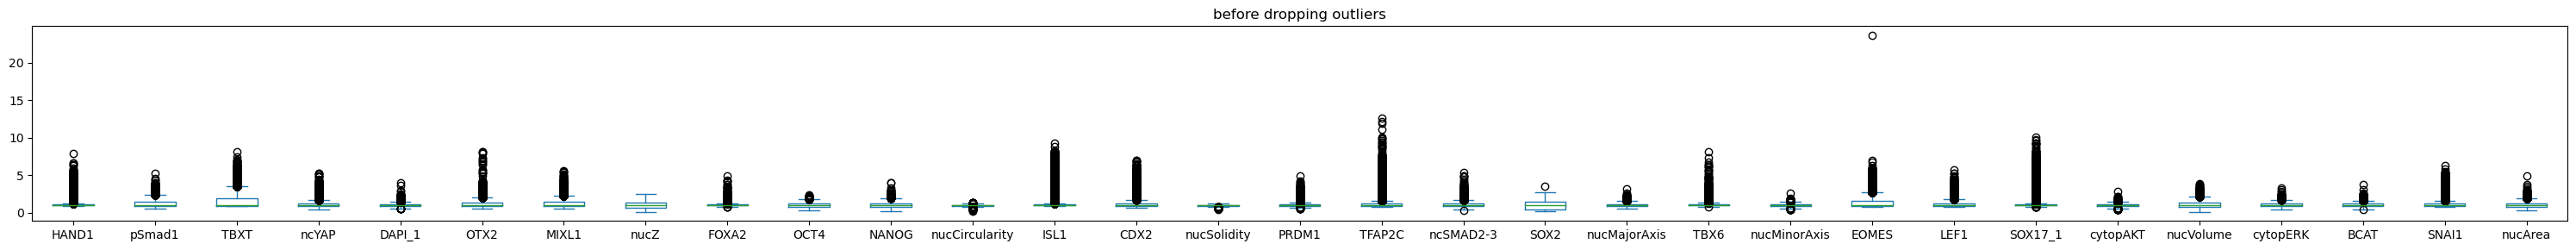

In [9]:
# make a boxplot of data normalized to the median to look for other outlier behavior 
plt.rcParams["figure.figsize"] = [30, 3]
plt.rcParams["figure.autolayout"] = True

# normalizing colony number, and coordinates makes no sense so exclude
norm_list = list(set(keep_list)- set(['Colony','X','Y','Z','RadialDist']))
data_norm = data.copy();
data_norm[norm_list] = data_norm[norm_list]/np.median(data[norm_list],axis=0);

data_norm[norm_list].plot(kind='box', title='boxplot')
plt.title('before dropping outliers')
plt.show()

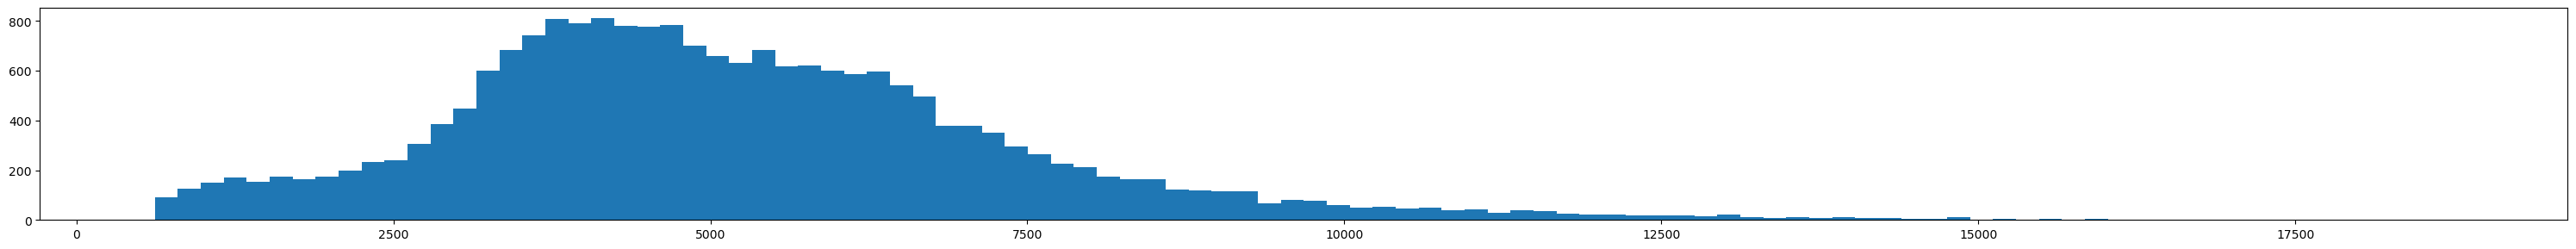

In [10]:
# inspect individual distributions if needed
plt.hist(data['nucVolume'], bins=100);

## Transform and visualize data

In [11]:
#log transform intensity measurements, possibly exclude nuclear to cytoplasmic ratios from transformation

#log_transform_list = marker_list + list(set(signal_list) - set(['ncYAP', 'ncSMAD2-3'])) + ['DAPI_1']
log_transform_list = marker_list + signal_list

data_log = data_norm.copy();
data_log[log_transform_list] = np.log2(1+data_norm[log_transform_list])

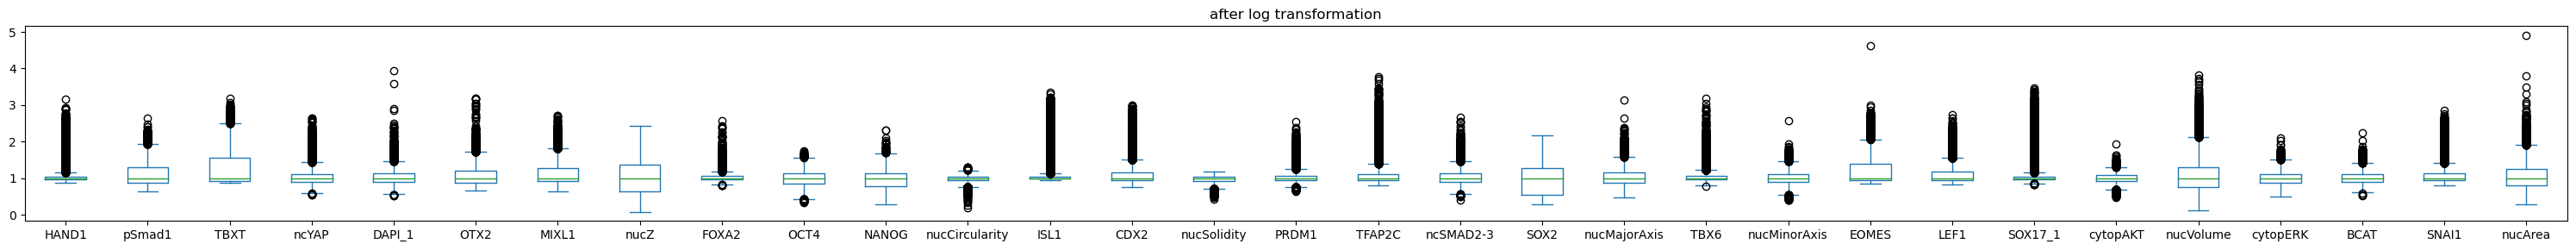

In [12]:
### log transformation ###

plt.rcParams["figure.figsize"] = [30, 3]
plt.rcParams["figure.autolayout"] = True
data_log[norm_list].plot(kind='box', title='boxplot')
plt.title('after log transformation')
plt.show()

In [13]:
# make UMAP based on marker genes alone
#data_log_umap = umap.UMAP().fit_transform(data_log[marker_list])
# use min_dist to spread out points 
data_log_umap = umap.UMAP(min_dist=0.4).fit_transform(data_log[marker_list])
data_log_umap = pd.DataFrame(data_log_umap, index=data_log.index)

/opt/anaconda3/envs/Mplex_analysis/lib/python3.8/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


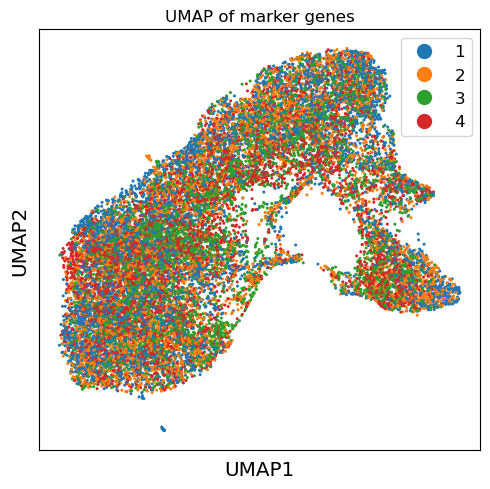

In [14]:
scprep.plot.scatter2d(data_log_umap, c=data_log['Colony'], label_prefix='UMAP',figsize=(5,5), ticks=False)
plt.title('UMAP of marker genes')
plt.show()

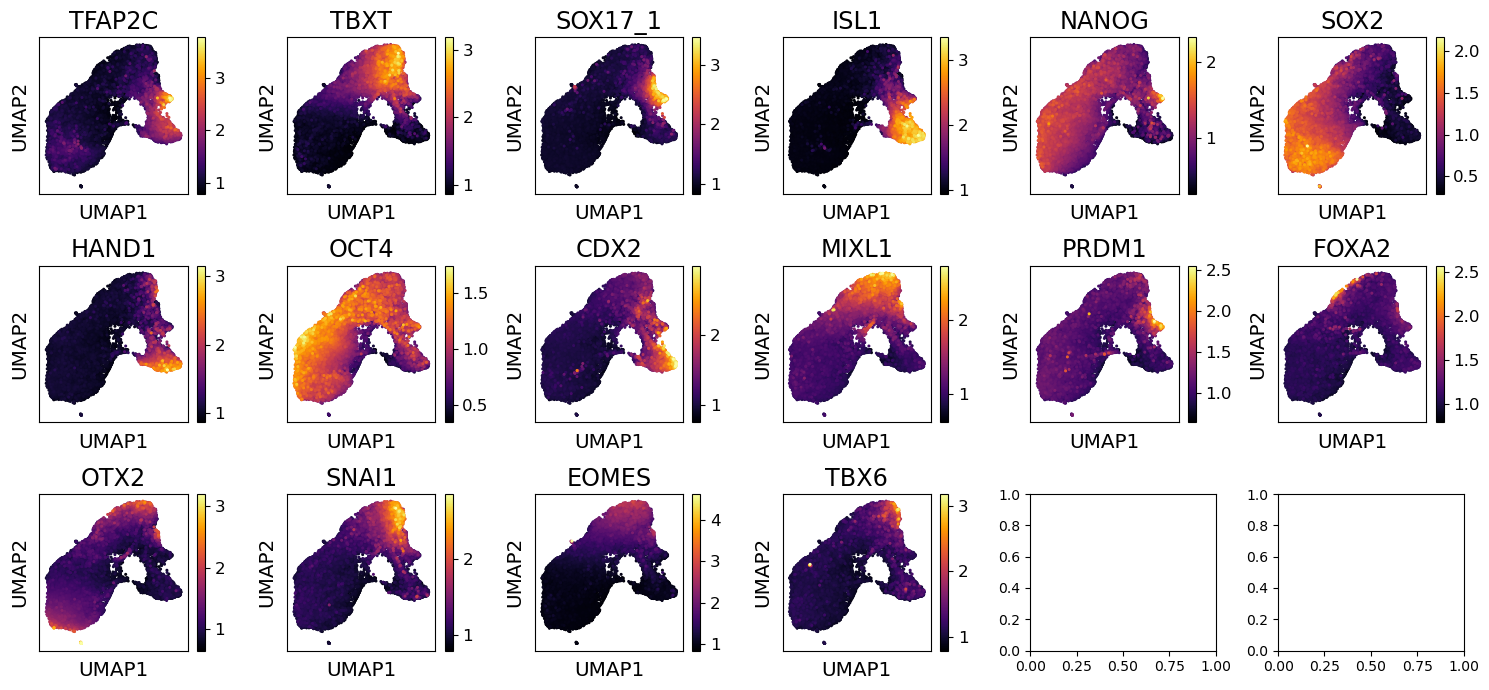

In [15]:
# visualize markers 
u_cdata = data_log_umap
m_cdata = data_log[marker_list]

#marker_labels = m_cdata.columns[:-5] 
marker_labels = m_cdata.columns[:] 
fig, axes = plt.subplots(3,6, figsize=(15,7))

for curr_gene, ax in zip(marker_labels, axes.flatten()):
    
    expression = scprep.select.select_cols(m_cdata, exact_word=curr_gene)
    sort_index = expression.sort_values().index
    scprep.plot.scatter2d(u_cdata.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                         title=curr_gene, ticks=None, label_prefix='UMAP', ax=ax)

fig.tight_layout()
plt.show()

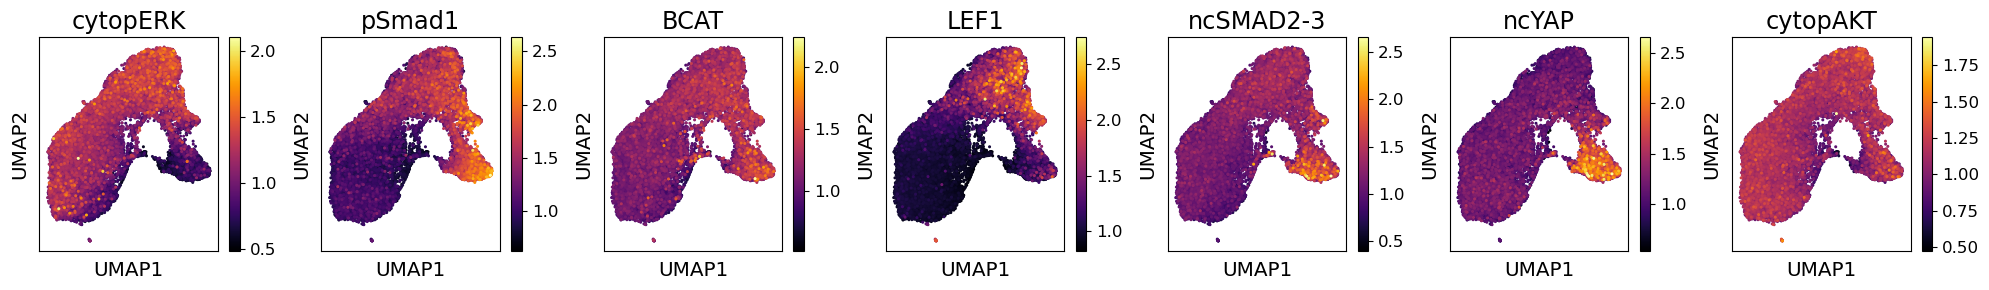

In [16]:
# visualize signaling 
u_cdata = data_log_umap
m_cdata = data_log[signal_list]

#marker_labels = m_cdata.columns[:-5] 
marker_labels = m_cdata.columns[:] 
fig, axes = plt.subplots(1,7, figsize=(20,3))

for curr_gene, ax in zip(marker_labels, axes.flatten()):
    
    expression = scprep.select.select_cols(m_cdata, exact_word=curr_gene)
    sort_index = expression.sort_values().index
    scprep.plot.scatter2d(u_cdata.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                         title=curr_gene, ticks=None, label_prefix='UMAP', ax=ax)

fig.tight_layout()
plt.show()

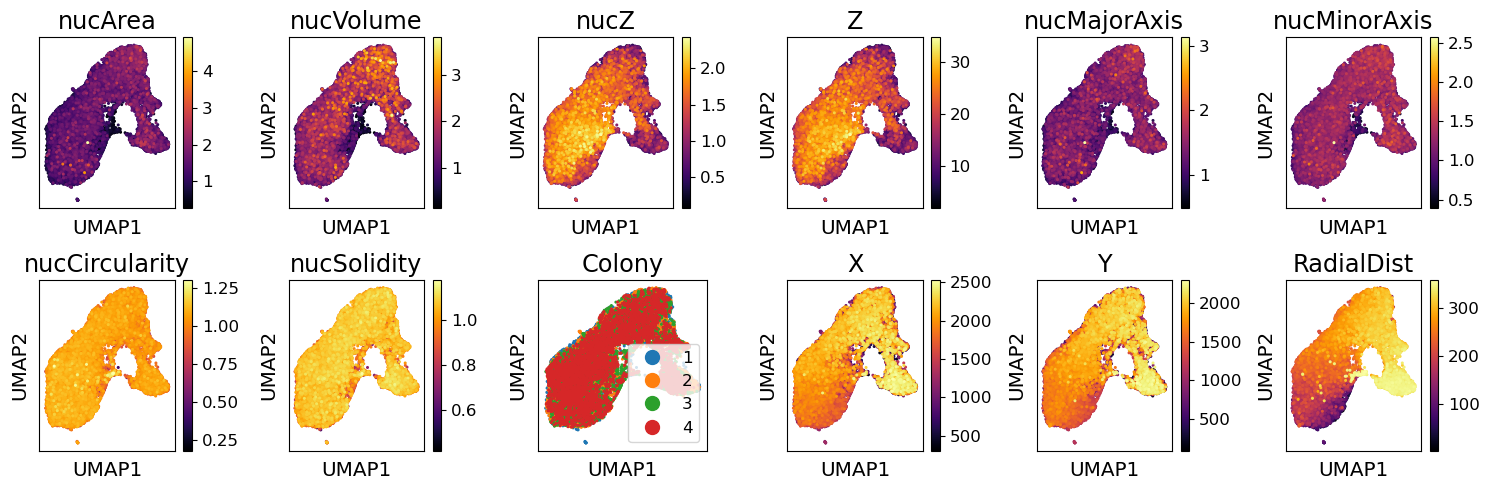

In [17]:
# visualize metadata (really cell shape and position)

u_cdata = data_log_umap
m_cdata = data_log[meta_list];

marker_labels = m_cdata.columns[:] 
fig, axes = plt.subplots(2,6, figsize=(15,5))

for curr_gene, ax in zip(meta_list, axes.flatten()):

    expression = scprep.select.select_cols(m_cdata, exact_word=curr_gene)    
    
    sort_index = expression.sort_values().index 
    scprep.plot.scatter2d(u_cdata.loc[sort_index], c=data_log[curr_gene].loc[sort_index], shuffle=False,
                         title=curr_gene, ticks=None, label_prefix='UMAP', ax=ax)


fig.tight_layout()
plt.show()

## Clustering

In [18]:
# # louvain clustering with ONLY markers
G = gt.Graph(data_log[marker_list])
G_igraph = G.to_igraph()

with tasklogger.log_task('Louvain'):
    partition = louvain.find_partition(G_igraph, louvain.RBConfigurationVertexPartition, 
                                       weights='weight', resolution_parameter=0.2,seed=11) #4,6,7 9 only has 2 small clusters
    louvain_clusters = np.array(partition.membership)
louvain_clusters
data_log['Cluster'] = louvain_clusters

Calculating Louvain...
Calculated Louvain in 0.30 seconds.


/opt/anaconda3/envs/Mplex_analysis/lib/python3.8/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


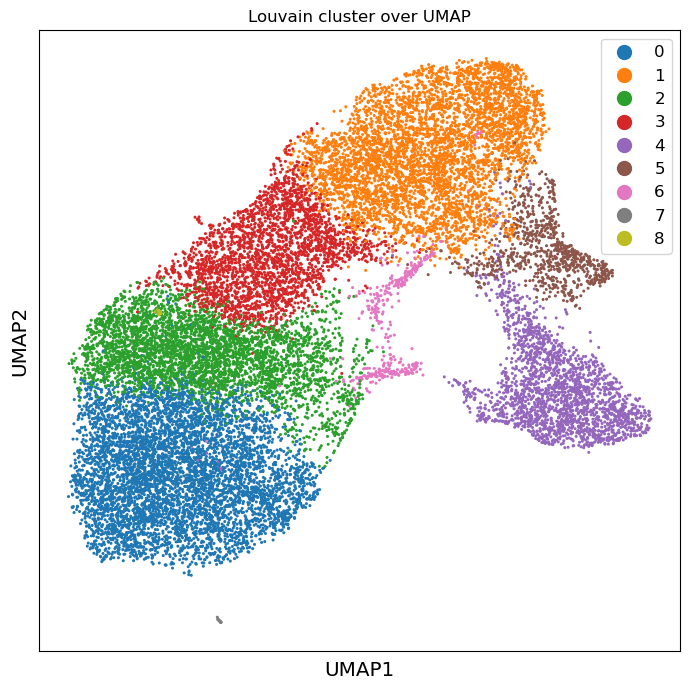

In [19]:
scprep.plot.scatter2d(u_cdata, c=louvain_clusters, shuffle=False,
                         title=curr_gene, ticks=None, label_prefix='UMAP',figsize=(7,7))
plt.title('Louvain cluster over UMAP')
plt.show()

In [20]:
# check size of each cluster
Counter(louvain_clusters)

Counter({4: 2128,
         5: 850,
         1: 4631,
         6: 390,
         3: 2644,
         0: 5891,
         2: 3977,
         7: 14,
         8: 11})

In [21]:
# to identify clusters, make heatmap

# start with zscore, exclude last column which is cluster
data_log_zscore = sklearn.preprocessing.StandardScaler().fit_transform(data_log.iloc[:,:-1]) 
clusters = data_log['Cluster']

Nclusters = int(np.max(clusters+1))
Ngenes = data_log.shape[1]-1;

cluster_means = np.zeros((Nclusters, Ngenes))
cluster_means_zscore = np.zeros((Nclusters, Ngenes))

for i in range(0, Nclusters) :
    cluster_means[i,:] = np.mean(data_log.loc[clusters==i,data_log.columns[:-1]],axis=0)
    cluster_means_zscore[i,:] = np.mean(data_log_zscore[clusters==i,:],axis=0)

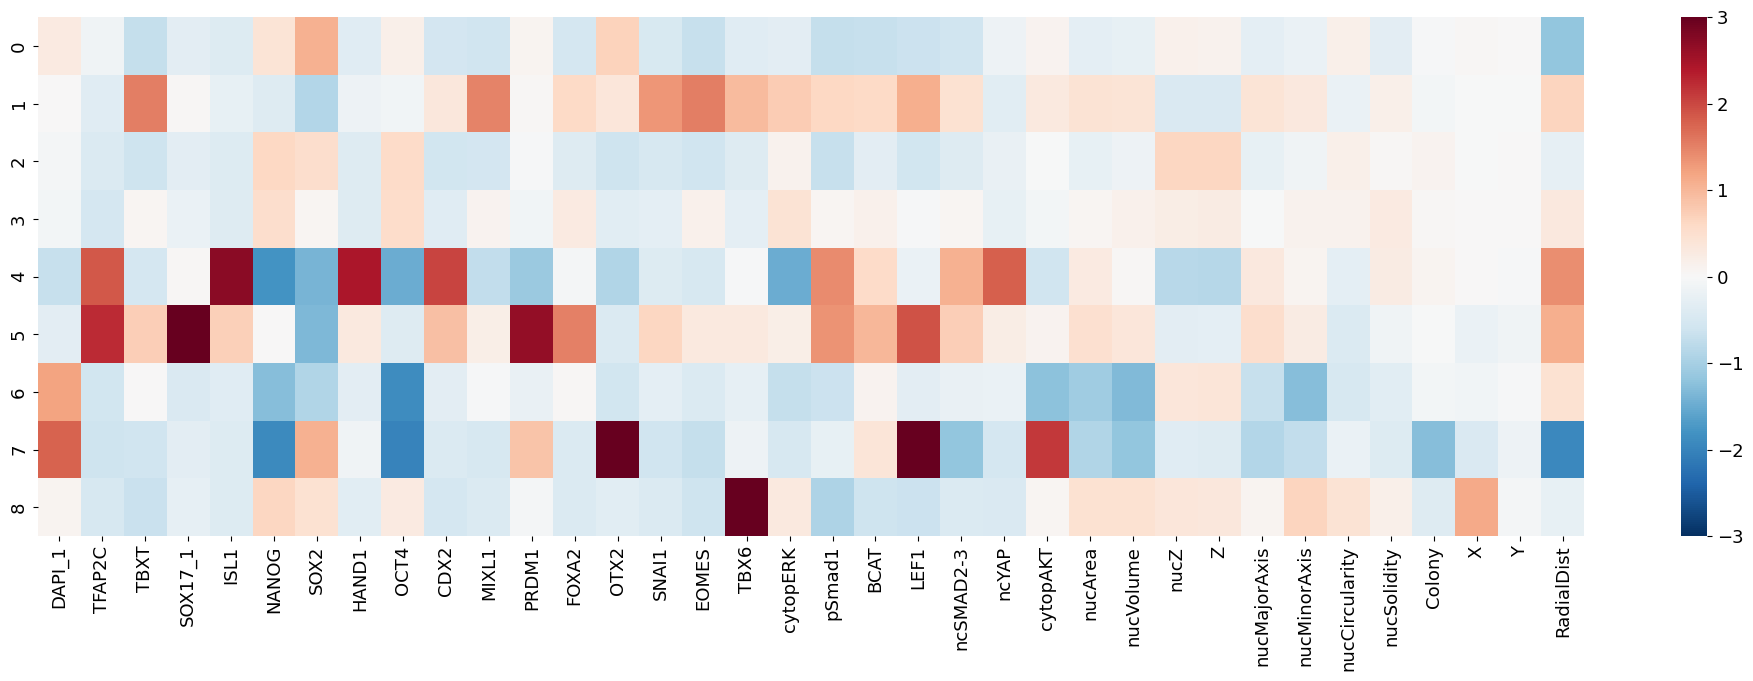

In [22]:
#Visualize heatmap with all columns
cluster_means = pd.DataFrame(cluster_means, columns=data_log.columns[:-1])#, index=clusterlabels)
cluster_means_zscore = pd.DataFrame(cluster_means_zscore, columns=data_log.columns[:-1])#, index=clusterlabels)

plt.rcParams.update({'font.size':13})
plt.rcParams.update({'font.weight':'regular'})
plt.rcParams.update({'axes.linewidth': 2})

plt.rcParams["figure.figsize"] = [20, 7]
g = sb.heatmap(cluster_means_zscore, xticklabels=cluster_means_zscore.columns,vmax=3,vmin=-3,
               cmap='RdBu_r')#,yticklabels=cluster_labels)

# or hierarchical cluster
#g = sb.clustermap(fatemarker_cluster_means_zscore, xticklabels=fatemarker_cluster_means_zscore.columns,vmax=3,vmin=-3,dendrogram_ratio=0.1,figsize=(18,10),cbar_pos=(0.01,0.01,0.03,0.2),cmap='RdBu_r')#,yticklabels=cluster_labels)
#plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
#plt.setp(g.ax_heatmap.get_xticklabels(), rotation=80)

plt.show()

In [23]:
# also check distribution of clusters across colonies
data_log.groupby(['Cluster','Colony']).size()

Cluster  Colony
0        1         1671
         2         1651
         3         1197
         4         1372
1        1         1403
         2         1164
         3         1110
         4          954
2        1         1026
         2          779
         3         1147
         4         1025
3        1          686
         2          659
         3          628
         4          671
4        1          484
         2          576
         3          520
         4          548
5        1          245
         2          192
         3          214
         4          199
6        1          106
         2          119
         3           89
         4           76
7        1           14
8        2           11
dtype: int64

loading /Users/emily/LocalHeemskerkLab/Papers/code/processed_data/230111_6i9rd_exp20_RD2_GATA3_OTX2_LEF1/MIP/stitched_MIP_p0000_w0000_t0000.jpg
loading /Users/emily/LocalHeemskerkLab/Papers/code/processed_data/230111_6i9rd_exp20_RD2_GATA3_OTX2_LEF1/MIP/stitched_MIP_p0000_w0002_t0000.jpg


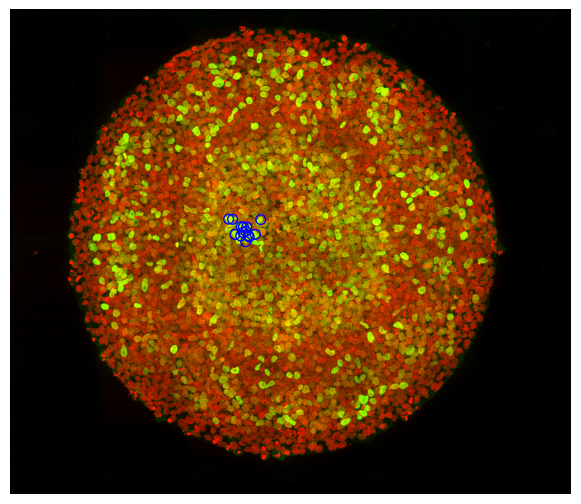

In [24]:
# check cluster 7, which is only in colony 1 and has high OTX2
# -> for some reason there are just a few cells with really high OTX2 -

plt.rcParams['figure.figsize']=(6,6) 
stains = ['DAPI_1','OTX2'] # stains, in order RGB
coli = 1; # colony index
cli = 7;

RGBoverlay = makeRGBoverlay(coli, stains)
plt.imshow(RGBoverlay);
plt.axis('off');

idx = (data_log['Cluster']==cli) & (data_log['Colony']==coli)
X = data_log.loc[idx]['X']
Y = data_log.loc[idx]['Y']

plt.scatter(X,Y,s=50, facecolors='none', edgecolors='b');

loading /Users/emily/LocalHeemskerkLab/Papers/code/processed_data/230111_6i9rd_exp20_RD2_GATA3_OTX2_LEF1/MIP/stitched_MIP_p0001_w0000_t0000.jpg
loading /Users/emily/LocalHeemskerkLab/Papers/code/processed_data/230115_6i9rd_exp20_RD6_BCAT_TBX6_SMAD2/MIP/stitched_MIP_p0001_w0002_t0000.jpg


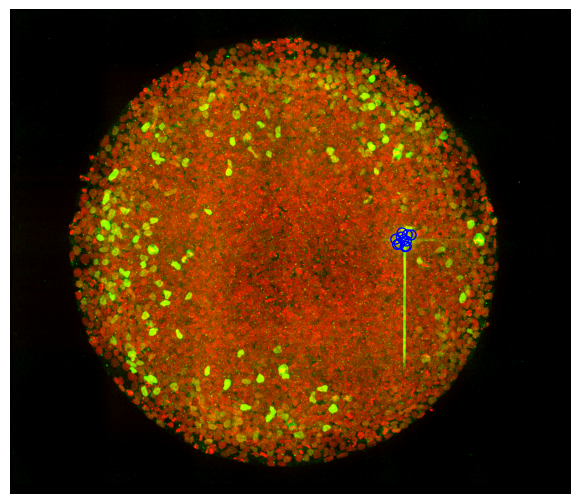

In [25]:
# check cluster 8, which is only in colony 2 and has high TBX6 
# --> this turns out to be a piece of junk

plt.rcParams['figure.figsize']=(6,6) 
stains = ['DAPI_1','TBX6'] # stains, in order RGB
coli = 2; # colony index
cli = 8;

RGBoverlay = makeRGBoverlay(coli, stains);
plt.imshow(RGBoverlay);
plt.axis('off');

idx = (data_log['Cluster']==cli) & (data_log['Colony']==coli)
X = data_log.loc[idx]['X']
Y = data_log.loc[idx]['Y']

plt.scatter(X,Y,s=50, facecolors='none', edgecolors='b');

loading /Users/emily/LocalHeemskerkLab/Papers/code/processed_data/230111_6i9rd_exp20_RD2_GATA3_OTX2_LEF1/MIP/stitched_MIP_p0001_w0000_t0000.jpg


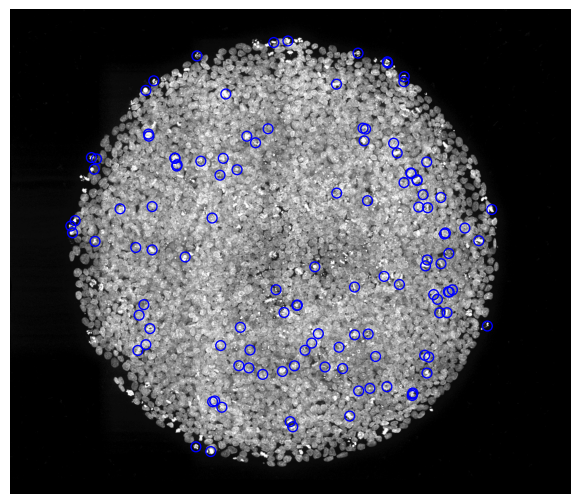

In [26]:
# check cluster 6, which is evenly spread across clusters and has high DAPI
# --> this looks like mostly mitotic cells

plt.rcParams['figure.figsize']=(6,6) 
stains = ['DAPI_1'] # stains, in order RGB
coli = 2; # colony index
cli = 6;

tol = [[1,99],[1,99],[1,99]] # tolerances for contrast adjustment
RGBoverlay = makeRGBoverlay(coli, stains, tol)
plt.imshow(RGBoverlay, cmap='gray');
plt.axis('off');

idx = (data_log['Cluster']==cli) & (data_log['Colony']==coli)
X = data_log.loc[idx]['X']
Y = data_log.loc[idx]['Y']

plt.scatter(X,Y,s=50, facecolors='none', edgecolors='b')

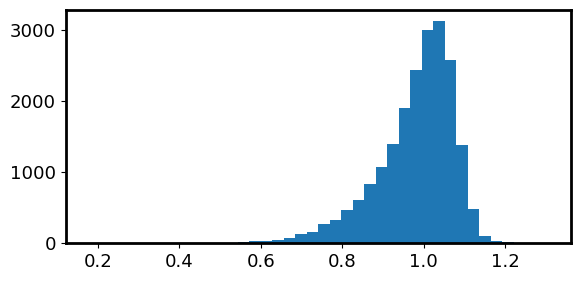

In [27]:
# look at distribution of circularity 
plt.rcParams['figure.figsize']=(6,3) 
plt.hist(data_log['nucCircularity'],bins=40);

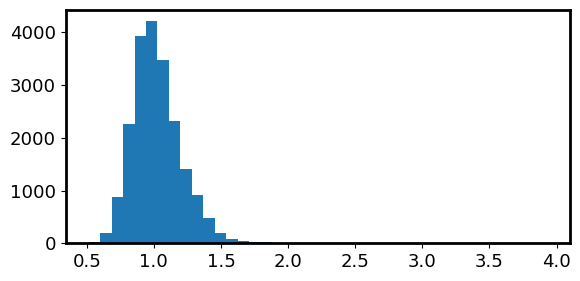

In [28]:
# look at distribution of DAPI
plt.rcParams['figure.figsize']=(6,3) 
plt.hist(data_log['DAPI_1'],bins=40);

loading /Users/emily/LocalHeemskerkLab/Papers/code/processed_data/230111_6i9rd_exp20_RD2_GATA3_OTX2_LEF1/MIP/stitched_MIP_p0001_w0000_t0000.jpg


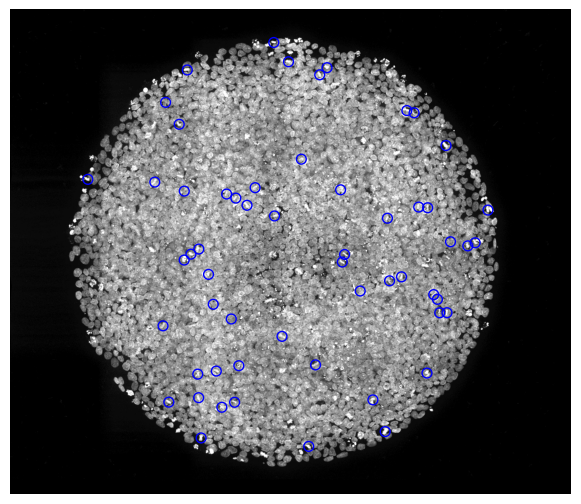

In [29]:
# check to what extent mitotic cells or cluster seven can be obtained by thresholding shape and DAPI

plt.rcParams['figure.figsize']=(6,6) 
stains = ['DAPI_1'] # stains, in order RGB
coli = 2; # colony index
cli = 7;

tol = [[1,99],[1,99],[1,99]] # tolerances for contrast adjustment
RGBoverlay = makeRGBoverlay(coli, stains, tol);
plt.imshow(RGBoverlay, cmap='gray');
plt.axis('off');

#idx = ((data_log['Colony']==coli))
idx = (((data_log['nucMinorAxis'] < 0.6) & (data_log['nucCircularity'] < 1) & (data_log['Colony']==coli)) & (data_log['DAPI_1'] > 1) )
X = data_log.loc[idx]['X']
Y = data_log.loc[idx]['Y']

plt.scatter(X,Y,s=50, facecolors='none', edgecolors='b')

In [30]:
# now assign cluster labels
cluster_labels=['ectodermLC','PSLC','pluri','iMeLC','amnionLC','PGCLC','mitotic','highOTX2','junk']
data_log['Cluster'] = louvain_clusters
data_log['Cluster_label'] = data_log['Cluster'];

for i in range(0, len(cluster_labels)):
    data_log.loc[data_log['Cluster']==i,'Cluster_label'] = cluster_labels[i];

In [31]:
# remove the junk cluster, and the highOTX2 cluster since it only has a few cells 
goodidx = ~((data_log['Cluster_label']=='highOTX2') | (data_log['Cluster_label']=='junk'));
data_log = data_log[goodidx]
cluster_labels_reduced=['ectodermLC','PSLC','pluri','iMeLC','amnionLC','PGCLC','mitotic']

u_cdata = data_log_umap
u_cdata = u_cdata[goodidx]

/opt/anaconda3/envs/Mplex_analysis/lib/python3.8/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


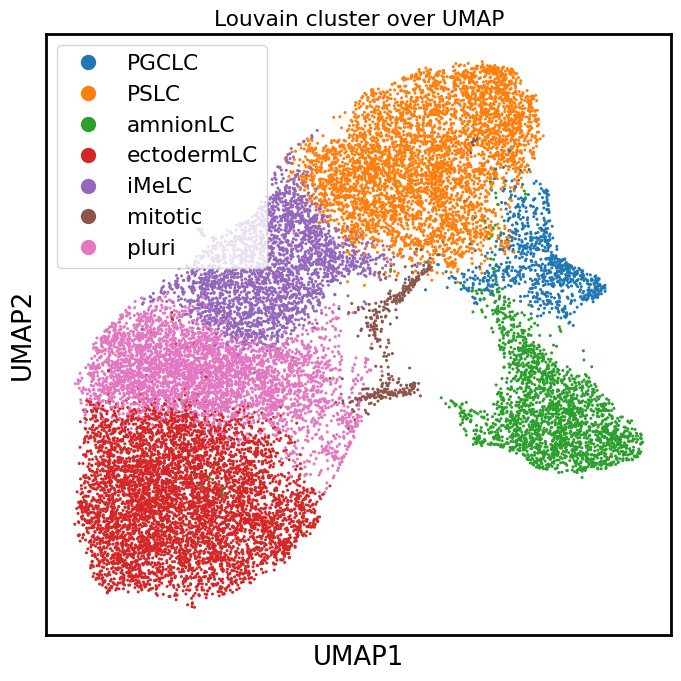

In [32]:
# visualize new cleaned up UMAP
scprep.plot.scatter2d(u_cdata, c=data_log['Cluster_label'], shuffle=False,
                         title=curr_gene, ticks=None, label_prefix='UMAP',figsize=(7,7))
plt.title('Louvain cluster over UMAP')
plt.show()

## Signaling and marker clustermap 

In [33]:
# to identify clusters, make heatmap

# start with zscore, exclude last column which is cluster
data_log_zscore = sklearn.preprocessing.StandardScaler().fit_transform(data_log.iloc[:,:-1]) 
clusters = data_log['Cluster']

uniqueclusters = np.unique(clusters);
Nclusters = len(uniqueclusters)
Ngenes = data_log.shape[1]-1;

cluster_means = np.zeros((Nclusters, Ngenes))
cluster_means_zscore = np.zeros((Nclusters, Ngenes))

for i in range(0, Nclusters) :
    cluster_means[i,:] = np.mean(data_log.loc[clusters==uniqueclusters[i],data_log.columns[:-1]],axis=0)
    cluster_means_zscore[i,:] = np.mean(data_log_zscore[clusters==uniqueclusters[i],:],axis=0)

/opt/anaconda3/envs/Mplex_analysis/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


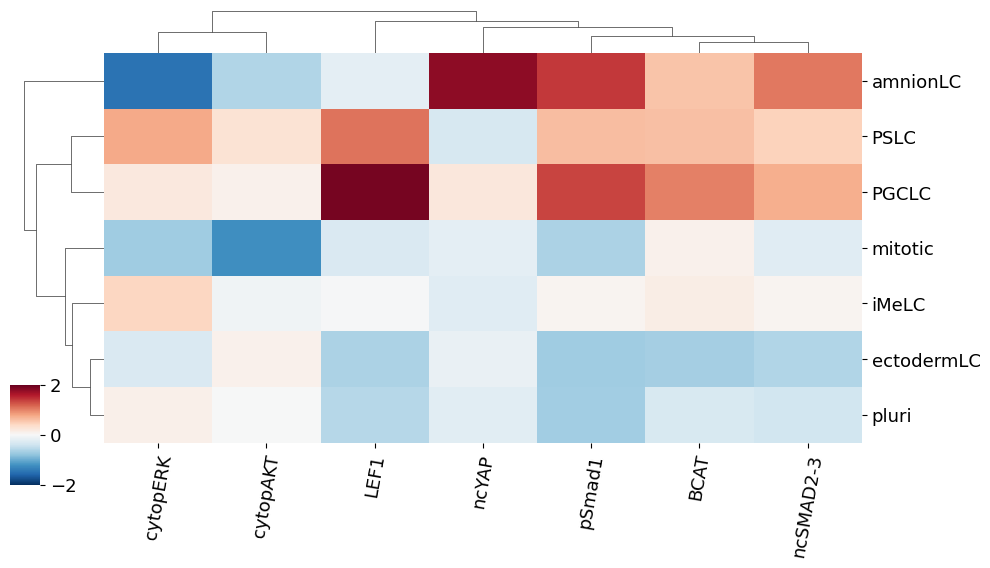

/opt/anaconda3/envs/Mplex_analysis/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


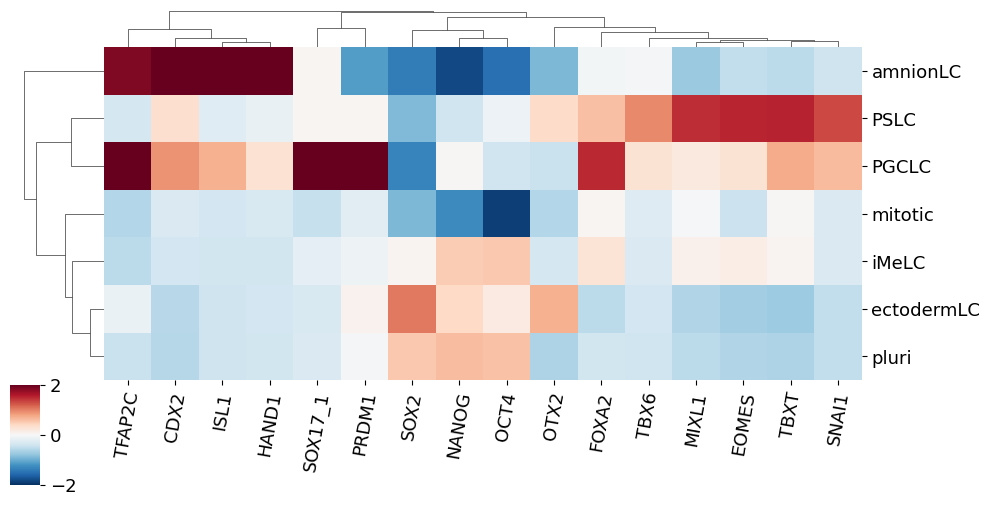

In [34]:
# visualize
cluster_means = pd.DataFrame(cluster_means, columns=data_log.columns[:-1], index=cluster_labels_reduced)
cluster_means_zscore = pd.DataFrame(cluster_means_zscore, columns=data_log.columns[:-1], index=cluster_labels_reduced)

row_linkage = scipy.cluster.hierarchy.linkage(cluster_means_zscore[signal_list], method='average');

# or hierarchical cluster
g = sb.clustermap(cluster_means_zscore[signal_list], row_linkage=row_linkage, xticklabels=signal_list,vmax=2,vmin=-2,dendrogram_ratio=0.1,figsize=(10,5),cbar_pos=(0.01,0.01,0.03,0.2),cmap='RdBu_r')#,yticklabels=cluster_labels)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=80)

plt.show()

# or hierarchical cluster
g = sb.clustermap(cluster_means_zscore[marker_list], row_linkage=row_linkage, xticklabels=marker_list,vmax=2,vmin=-2,dendrogram_ratio=0.1,figsize=(10,5),cbar_pos=(0.01,0.01,0.03,0.2),cmap='RdBu_r')#,yticklabels=cluster_labels)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=80)

plt.show()

## Spatial analysis

loading /Users/emily/LocalHeemskerkLab/Papers/code/processed_data/230111_6i9rd_exp20_RD2_GATA3_OTX2_LEF1/MIP/stitched_MIP_p0001_w0000_t0000.jpg


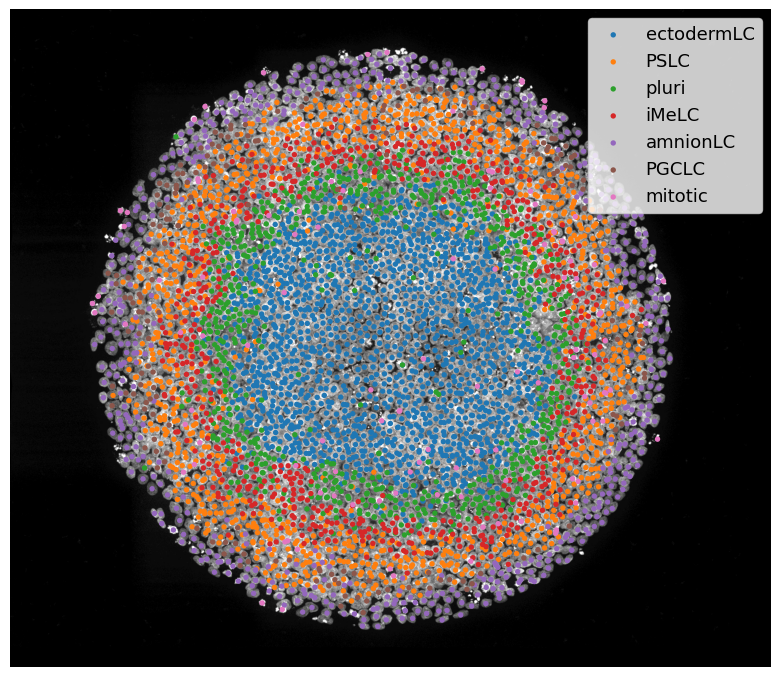

In [35]:
# map the clusters back to space and overlay on DAPI image

coli = 2; # colony index
RGBoverlay = makeRGBoverlay(coli, ['DAPI']);

plt.rcParams['figure.figsize']=(8,8) 
fig, ax = plt.subplots()
ax.imshow(RGBoverlay, cmap='gray');
ax.axis('off');

for i in range(0,Nclusters):

    idx = (data_log['Colony']==coli) & (data_log['Cluster']==i);
    X = data_log.loc[idx]['X']
    Y = data_log.loc[idx]['Y']
    C = data_log.loc[idx]['Cluster']
    scatter = ax.scatter(X,Y,s=15, edgecolors='none');
    
plt.legend(cluster_labels_reduced)

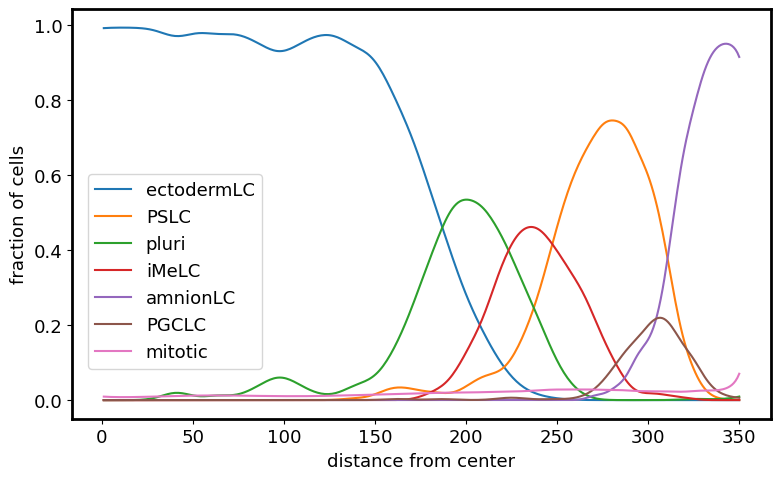

In [36]:
plt.rcParams['figure.figsize']=(8,5) 

clusterdensities = {};
r = np.linspace(0,350, num=350);
clusterdensities_sum = 0*r;

for i in range(0,Nclusters):

    idx = (data_log['Colony']==coli) & (data_log['Cluster']==i);
    R = data_log.loc[idx]['RadialDist']
    Z = gaussian_kde(R);
    Ncells = len(R);

    RZ = pd.concat([pd.Series(r),pd.Series(Z(r))],axis=1);
    RZ.rename(columns={0:'r',1:'Z'}, inplace=True);
    clusterdensity = Ncells*RZ['Z']/(2*3.14159*r)
    clusterdensities[i] = clusterdensity;
    clusterdensities_sum = clusterdensities_sum + clusterdensity;
    
for i in range(0,Nclusters):  
    clusterfraction = clusterdensities[i]/clusterdensities_sum;
    plt.plot(RZ['r'], clusterfraction);

plt.ylabel('fraction of cells');
plt.xlabel('distance from center');
plt.legend(cluster_labels_reduced,loc='lower left',bbox_to_anchor=(0.01, 0.1));